In [4]:
import pandas as pd
import warnings
from xgboost import XGBRegressor as xgb
import matplotlib.pyplot as plt
from itertools import product
import regex as re
import numpy as np
warnings.filterwarnings('ignore')

data = pd.read_csv('data0305.csv', index_col='Unnamed: 0')
data.sample(3)

,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,weekday,monthday,is_weekend,...,Demand_lag42d_w14D_keySKU_id_Store_id_preagmean_agperc90_is_weekend_dynamic_rolling,Demand_lag42d_w21D_keySKU_id_Store_id_preagmean_agmean_is_weekend_dynamic_rolling,Demand_lag42d_w21D_keySKU_id_Store_id_preagmean_agmedian_is_weekend_dynamic_rolling,Demand_lag42d_w21D_keySKU_id_Store_id_preagmean_agperc10_is_weekend_dynamic_rolling,Demand_lag42d_w21D_keySKU_id_Store_id_preagmean_agperc90_is_weekend_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_Store_id_preagmean_agmean_is_weekend_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_Store_id_preagmean_agmedian_is_weekend_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_Store_id_preagmean_agperc10_is_weekend_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_Store_id_preagmean_agperc90_is_weekend_dynamic_rolling,Promo_percent
89282,2016-06-03,45,1,0.0,NaN,130.07,130.07,4,3,0,...,2956.0,796.333333,346.0,168.2,2414.4,651.300,270.5,174.1,1792.4,0.0
30025,2015-07-18,38,1,0.0,1090.0,127.62,127.62,5,18,1,...,800.6,433.000000,242.0,171.0,886.0,385.125,242.0,176.6,824.4,0.0
79511,2016-04-16,16,1,0.0,374.0,135.78,135.78,5,16,1,...,428.3,530.500000,361.5,246.5,983.5,562.000,361.5,263.5,1176.7,0.0


## no lag features

In [5]:
data = data.drop(data.columns[data.columns.str.contains('lag')], axis=1)


In [6]:
target = 'Demand'
id_cols = ['SKU_id', 'Store_id']
date_col = 'Date'

data[date_col] = pd.to_datetime(data[date_col])
for c, sku, store in product(data.drop([date_col, target], axis=1).columns, 
                             data[id_cols[0]].unique(), data[id_cols[1]].unique()):
    cond = (data[id_cols[0]] == sku) & (data[id_cols[1]] == store)
    data.loc[cond, c] = data[cond][c].fillna(data[cond][c].mean())
    
for id_ in id_cols:
    for c in data.drop([date_col, target], axis=1).columns:
        for sku in data[id_].unique():
            cond = (data[id_] == sku)
            data.loc[cond, c] = data[cond][c].fillna(data[cond][c].mean())
    if data[data.drop([date_col, target], axis=1).columns].isna().sum().sum() == 0:
        break

In [7]:
data = data.set_index('Date')
train = data[data['Demand'].notna()]
test = data[data['Demand'].isna()]
X_train, X_test, y_train, y_test = train.drop('Demand', axis=1), test.drop('Demand', axis=1), train['Demand'], test['Demand']



In [10]:
model = xgb()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

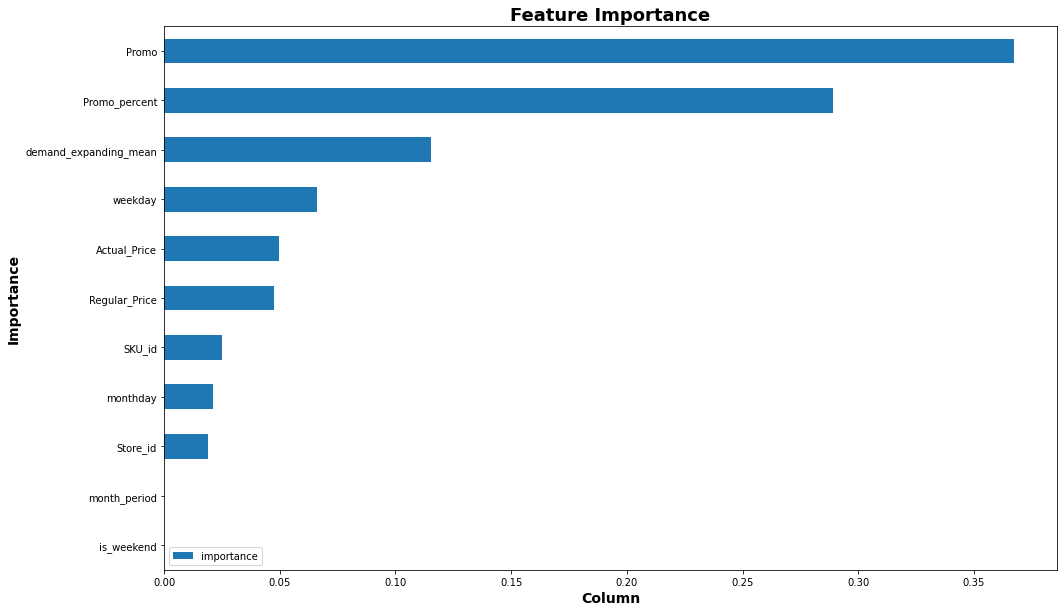

In [12]:
fi = pd.DataFrame({'column': X_train.columns, 'importance': model.feature_importances_})
fi.sort_values('importance', ascending=True).head(15).set_index('column').plot.barh(figsize=(16, 10))
plt.ylabel('Importance', weight='bold', size=14)
plt.xlabel('Column', weight='bold', size=14)
plt.title('Feature Importance', weight='bold', size=18)
plt.show()

In [13]:
## как и ожидалось самые важные признаки это promoи promo_percent

In [14]:
## save kaggle score

# test['pred'] = y_pred
# test.reset_index().sort_values(['SKU_id', 'Store_id', 'Date'])[['pred']].reset_index().drop('index', axis=1).\
# rename(columns={'pred': 'Demand'}).to_csv('xgb.csv', index_label='id')



## with lag features

In [17]:
from tqdm.notebook import tqdm

In [18]:
data = pd.read_csv('data0305.csv')

target = 'Demand'
id_cols = ['SKU_id', 'Store_id']
date_col = 'Date'

data[date_col] = pd.to_datetime(data[date_col])
for c, sku, store in tqdm(product(data.drop([date_col, target], axis=1).columns, 
                             data[id_cols[0]].unique(), data[id_cols[1]].unique())):
    cond = (data[id_cols[0]] == sku) & (data[id_cols[1]] == store)
    data.loc[cond, c] = data[cond][c].fillna(data[cond][c].mean())
    
for id_ in tqdm(id_cols):
    for c in data.drop([date_col, target], axis=1).columns:
        for sku in data[id_].unique():
            cond = (data[id_] == sku)
            data.loc[cond, c] = data[cond][c].fillna(data[cond][c].mean())
    if data[data.drop([date_col, target], axis=1).columns].isna().sum().sum() == 0:
        break

data = data.set_index('Date')

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
train = data[data['Demand'].notna()]
test = data[data['Demand'].isna()]
X_train, X_test, y_train, y_test = train.drop('Demand', axis=1), test.drop('Demand', axis=1), train['Demand'], test['Demand']

model = xgb()

model.fit(X_train, y_train, verbose=2)
y_pred = model.predict(X_test)


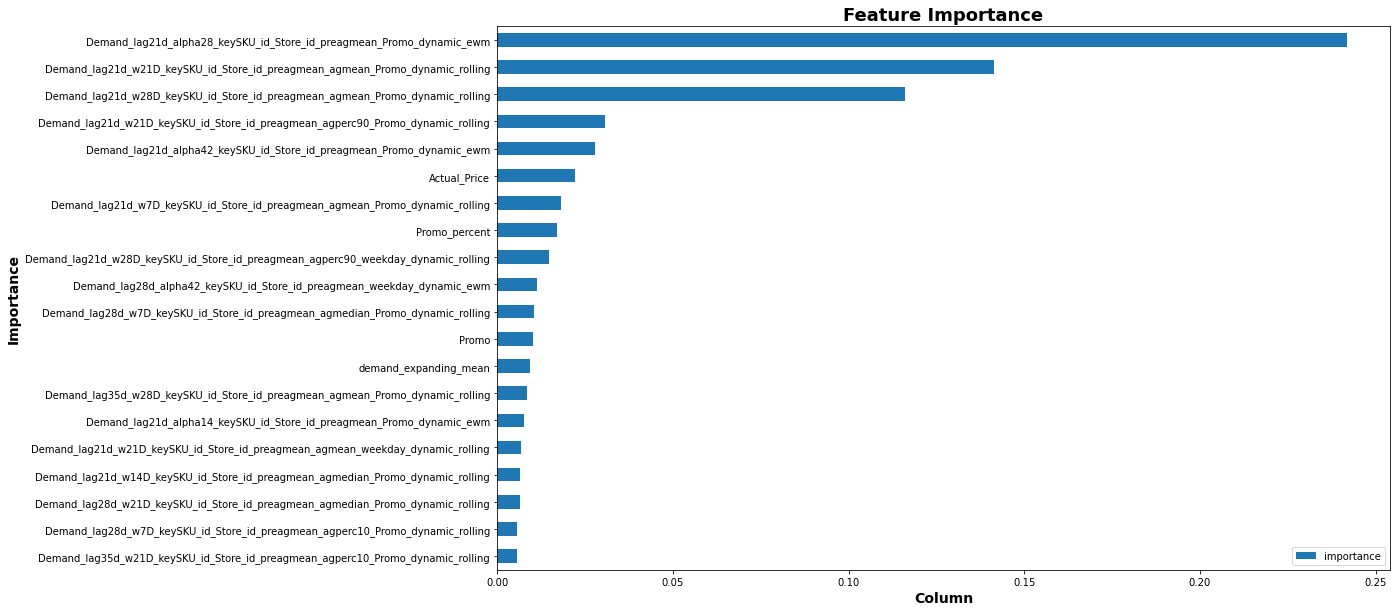

In [54]:
fi = pd.DataFrame({'column': X_train.columns, 'importance': model.feature_importances_})
fi.sort_values('importance', ascending=True).tail(20).set_index('column').plot.barh(figsize=(16, 10))
plt.ylabel('Importance', weight='bold', size=14)
plt.xlabel('Column', weight='bold', size=14)
plt.title('Feature Importance', weight='bold', size=18)
plt.show()

In [51]:
## save kaggle score
# test.reset_index().sort_values(['SKU_id', 'Store_id', 'Date'])[['pred']].reset_index().drop('index', axis=1).\
# rename(columns={'pred': 'Demand'}).to_csv('xgb.csv', index_label='id')



## check top features

In [99]:
df = fi[fi['column'].str.contains('lag')].reset_index(drop=True)
df['aggregation'] = df['column'].apply(lambda x: re.findall(r'_ag[a-z, 0-9]+', x)[0].replace('_ag', '') if len(re.findall(r'_ag[a-z, 0-9]+', x)) != 0 else 'ewm')

df['filter'] = df['column'].apply(lambda x: re.findall(r'_[a-z, A-Z, 0-9]+_dynamic', x)[0].replace('_dynamic', '').replace('_', ''))

df['window_type'] = df['column'].apply(lambda x: re.findall(r'dynamic_[a-z, A-Z, 0-9]+', x)[0].replace('dynamic_', ''))

df['lag'] = df['column'].apply(lambda x: re.findall(r'lag[a-z, A-Z, 0-9]+_', x)[0].replace('lag', ''))

df['window'] = df['column'].apply(lambda x: re.findall(r'_w[a-z, A-Z, 0-9]+_', x)[0].replace('_w', '') if len(re.findall(r'_w[a-z, A-Z, 0-9]+_', x)) != 0 else 'ewm')


In [94]:

df['window_type'] = df['column'].apply(lambda x: re.findall(r'dynamic_[a-z, A-Z, 0-9]+', x)[0].replace('dynamic_', ''))


<AxesSubplot:ylabel='aggregation'>

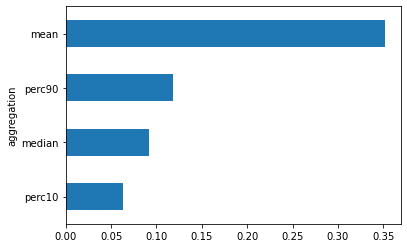

In [93]:
df[df['aggregation'] != 'ewm'].groupby('aggregation').sum()['importance'].sort_values().plot.barh()

<AxesSubplot:ylabel='filter'>

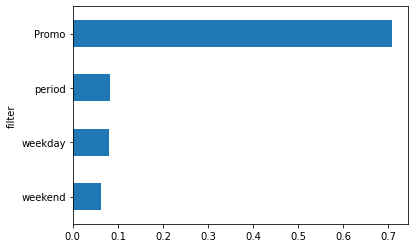

In [92]:
df.groupby('filter').sum()['importance'].sort_values().plot.barh()

<AxesSubplot:ylabel='window_type'>

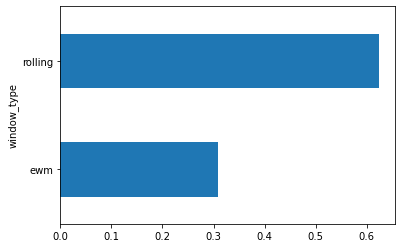

In [95]:
df.groupby('window_type').sum()['importance'].sort_values().plot.barh()

<AxesSubplot:ylabel='lag'>

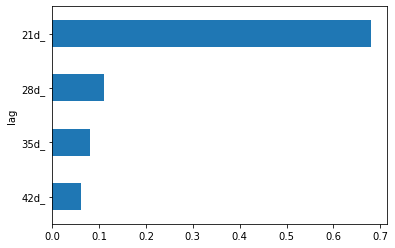

In [101]:
df.groupby('lag').sum()['importance'].sort_values().plot.barh()

<AxesSubplot:ylabel='lag'>

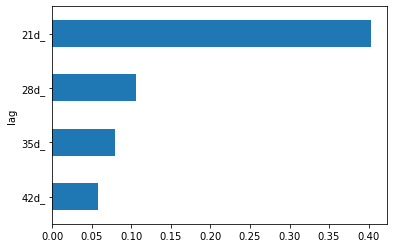

In [102]:
df[df['window'] != 'ewm'].groupby('lag').sum()['importance'].sort_values().plot.barh()